In [4]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import bnlearn as bn

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore")

In [7]:
# Load Titanic dataset from seaborn
df = sns.load_dataset('titanic')
#
train = pd.read_csv('./train.csv').set_index('PassengerId')
#
test = pd.read_csv('./test.csv').set_index('PassengerId')

In [8]:
df# Dropping columns with many unique values
drop_list = ['Name', 'Age', 'Cabin', 'Ticket', 'Fare']
train = train.drop(columns=drop_list)
test = test.drop(columns=drop_list)

In [9]:
# Data preparing
dfhot_train, dfnum_train = bn.df2onehot(train)
dfhot_test, dfnum_test = bn.df2onehot(test)


[df2onehot] >Auto detecting dtypes.


100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 111.11it/s]


[df2onehot] >Set dtypes in dataframe..


[df2onehot]: 100%|██████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 149.99it/s]


[df2onehot] >Total onehot features: 18

[df2onehot] >Auto detecting dtypes.


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 171.94it/s]


[df2onehot] >Set dtypes in dataframe..


[df2onehot]: 100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 192.94it/s]

[df2onehot] >Total onehot features: 14


In [11]:
dfnum_target = dfnum_train.pop('Survived')
Xtrain, Xval, Ztrain, Zval = train_test_split(dfnum_train, dfnum_target, test_size=0.2, random_state=0)
valid = pd.concat([Xval, Zval], axis='columns')
dfnum = pd.concat([Xtrain, Ztrain], axis='columns')
dfnum

,Pclass,Sex,SibSp,Parch,Embarked,Survived
140,3,0,1,3,1,0
439,2,1,1,1,3,0
817,2,1,2,2,1,0
378,3,1,1,1,1,0
491,3,1,1,1,3,0
...,...,...,...,...,...,...
835,1,0,2,2,1,1
192,3,0,2,1,3,1
629,3,1,1,1,2,0
559,3,0,2,1,3,1


In [12]:
# Get score
def get_acc(model, df, col):
    # Get accuracy score by the model for the validation dataset df with target col
    pred = bn.predict(model, df, variables=[col])
    print(pred)
    acc = accuracy_score(df[col], pred[col])
    print('Accuracy -', acc)
    return acc

[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [bic]
[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Set node properties.
[bnlearn] >Set edge properties.
[bnlearn] >Plot based on Bayesian model


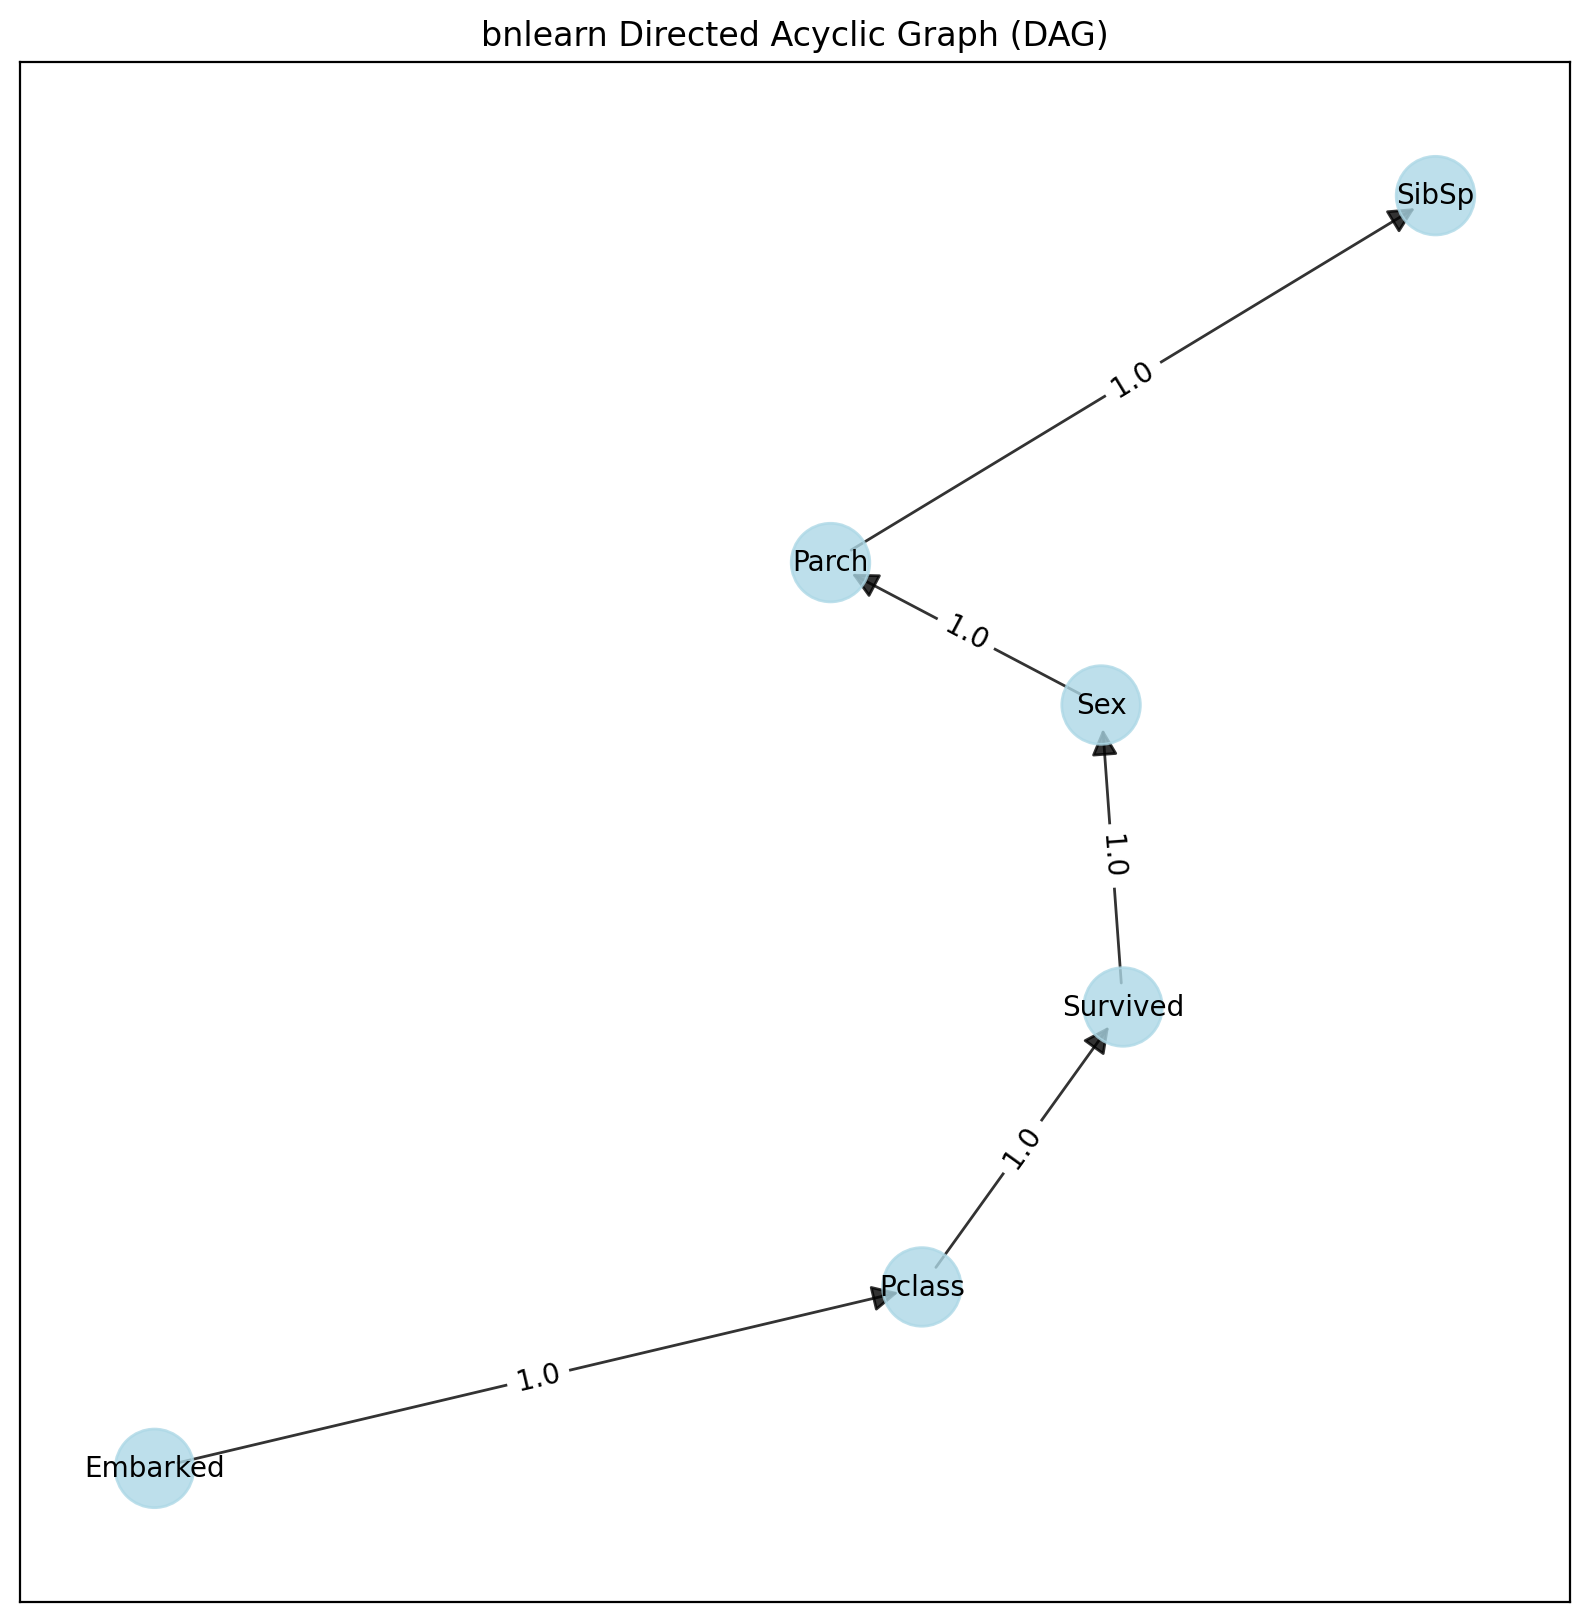

[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of Pclass:
+-----------+---------------------+---------------------+---------------------+---------------------+
| Embarked  | Embarked(0)         | Embarked(1)         | Embarked(2)         | Embarked(3)         |
+-----------+---------------------+---------------------+---------------------+---------------------+
| Pclass(1) | 0.3386243386243386  | 0.3834652594547054  | 0.26857749469214437 | 0.24554541503694044 |
+-----------+---------------------+---------------------+---------------------+---------------------+
| Pclass(2) | 0.33068783068783064 | 0.25945470536499565 | 0.2749469214437367  | 0.27553237722729246 |
+-----------+---------------------+---------------------+---------------------+---------------------+
| Pclass(3) | 0.33068783068783064 | 0.357080035180299   | 0.456475

In [13]:
%%time
# Structure learning
DAG = bn.structure_learning.fit(dfnum, methodtype='hc', root_node='Survived', bw_list_method='nodes', verbose=3)

# Plot
G = bn.plot(DAG)

# Parameter learning
model = bn.parameter_learning.fit(DAG, dfnum, verbose=3);

In [14]:
# About the model
model

{'model': <pgmpy.models.BayesianNetwork.BayesianNetwork at 0x250610a2a60>,
 'adjmat': target    Pclass    Sex  SibSp  Parch  Embarked  Survived
 source                                                   
 Pclass     False  False  False  False     False      True
 Sex        False  False  False   True     False     False
 SibSp      False  False  False  False     False     False
 Parch      False  False   True  False     False     False
 Embarked    True  False  False  False     False     False
 Survived   False   True  False  False     False     False,
 'config': {'verbose': 3, 'method': 'bayes', 'n_jobs': -1},
 'model_edges': [('Pclass', 'Survived'),
  ('Survived', 'Sex'),
  ('Sex', 'Parch'),
  ('Parch', 'SibSp'),
  ('Embarked', 'Pclass')],
 'structure_scores': {'k2': -3174.9527427131247,
  'bic': -3209.323591016362,
  'bdeu': -3172.76499432183,
  'bds': -3186.6279379330285},
 'independence_test': None}

In [15]:
# Get score of the model1
acc1 = get_acc(model, valid, 'Survived')

[bnlearn]> Remaining columns for inference: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 59/59 [00:00<00:00, 565.59it/s]

     Survived         p
0           0  0.725084
1           0  0.725084
2           0  0.725084
3           1  0.662098
4           0  0.507407
..        ...       ...
174         0  0.507407
175         0  0.725084
176         1  0.662098
177         0  0.725084
178         0  0.725084

[179 rows x 2 columns]
Accuracy - 0.8156424581005587


[bnlearn] >Filter variables (nodes) on black_list..
[bnlearn] >Number of features after white/black listing: 5
[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [bic]
[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Set node properties.
[bnlearn] >Set edge properties.
[bnlearn] >Plot based on Bayesian model


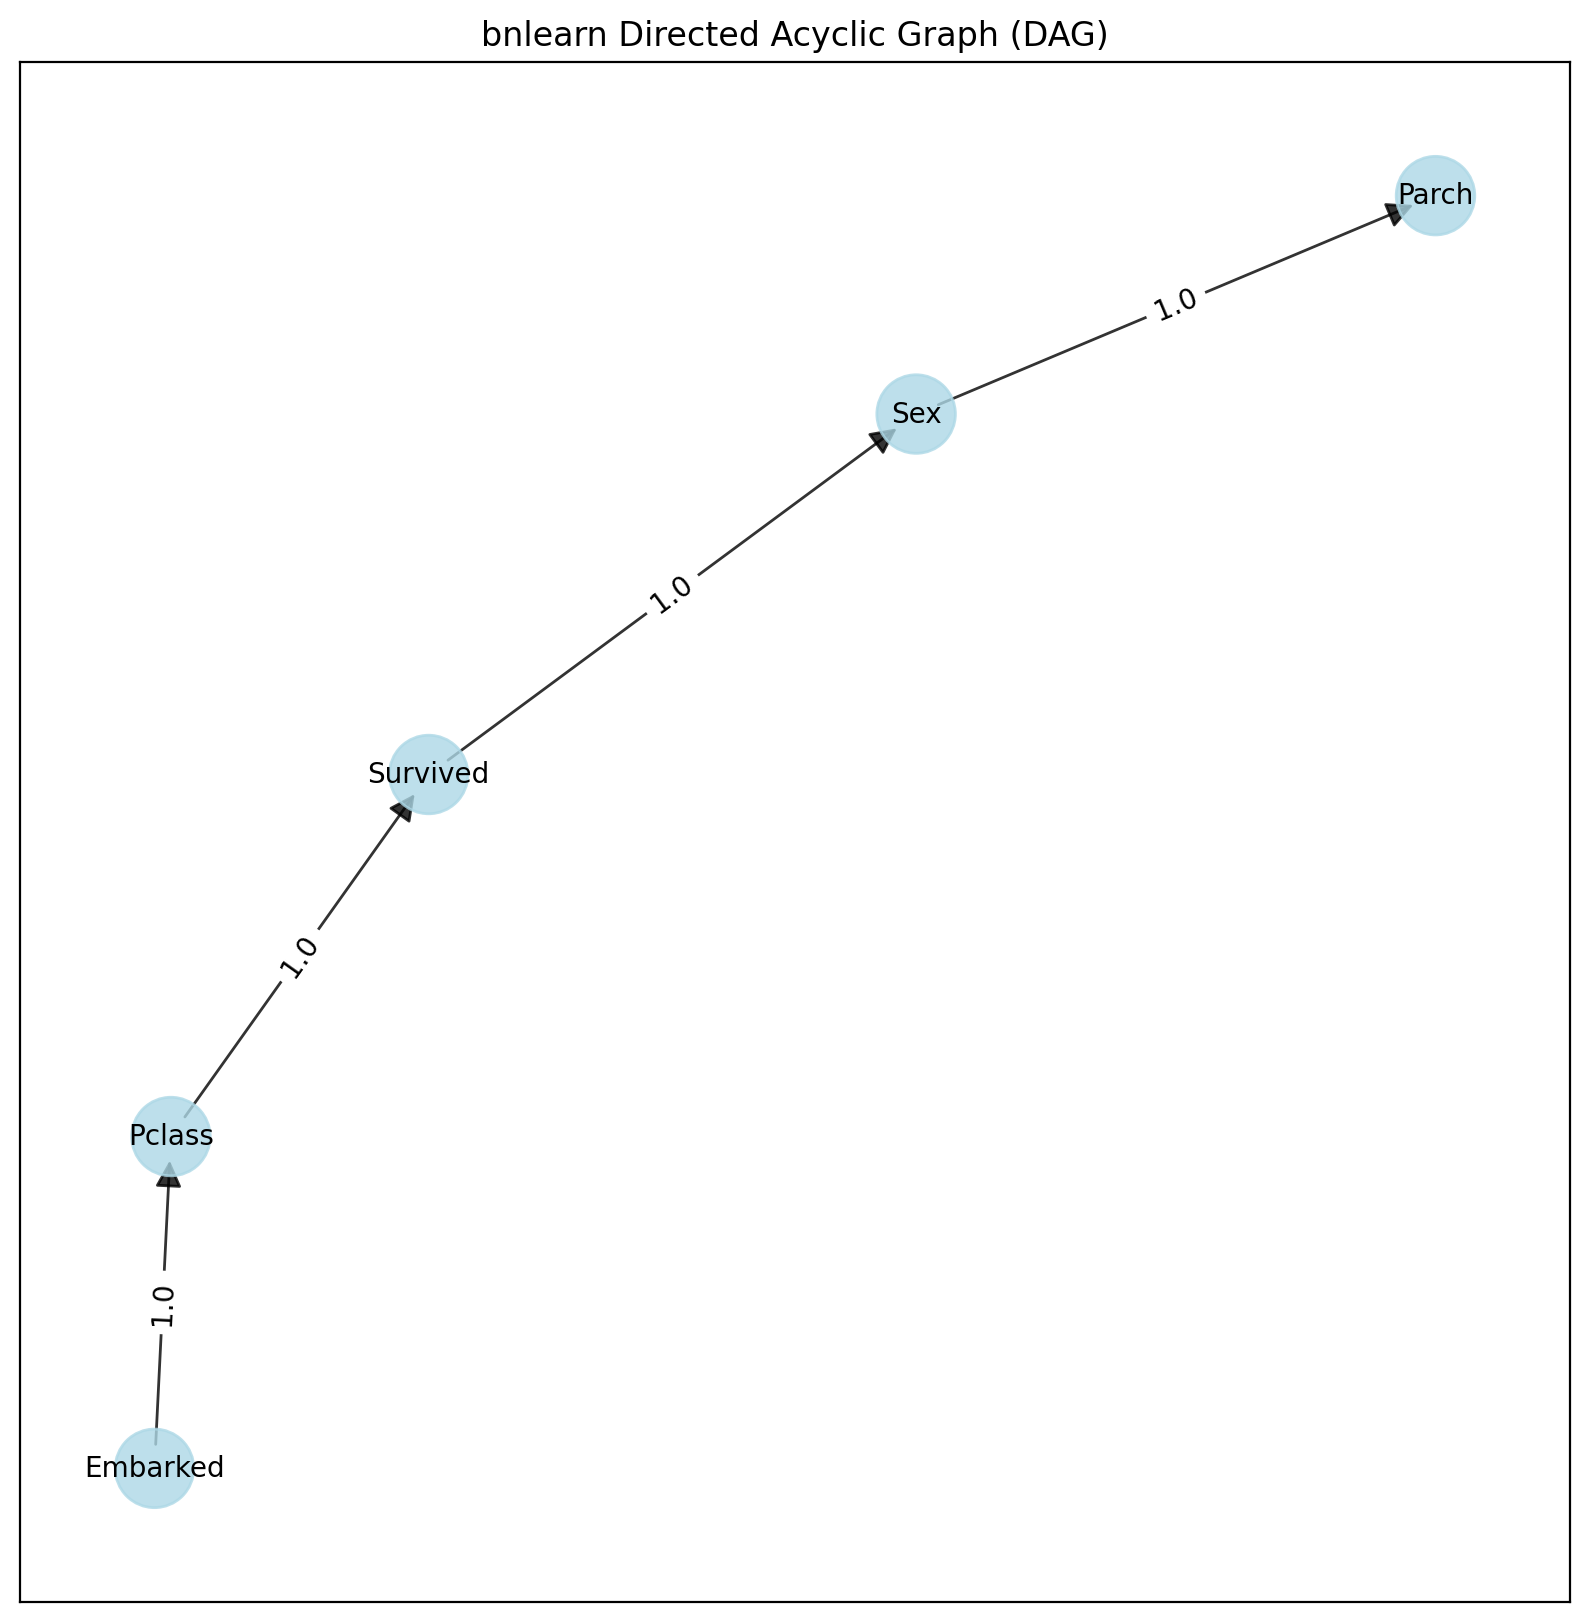

[bnlearn] >Removing columns from dataframe to make consistent with DAG [['SibSp']]
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of Pclass:
+-----------+---------------------+---------------------+---------------------+---------------------+
| Embarked  | Embarked(0)         | Embarked(1)         | Embarked(2)         | Embarked(3)         |
+-----------+---------------------+---------------------+---------------------+---------------------+
| Pclass(1) | 0.3386243386243386  | 0.3834652594547054  | 0.26857749469214437 | 0.24554541503694044 |
+-----------+---------------------+---------------------+---------------------+---------------------+
| Pclass(2) | 0.33068783068783064 | 0.25945470536499565 | 0.2749469214437367  | 0.27553237722729246 |
+-----------+---------------------+---------------------+---------------------+------

In [16]:
%%time
# Structure learning
DAG2 = bn.structure_learning.fit(dfnum, methodtype='hc', black_list=['SibSp'], root_node='Survived', bw_list_method='nodes', verbose=4)

# Plot
G2 = bn.plot(DAG2)

# Parameter learning
model2 = bn.parameter_learning.fit(DAG2, dfnum, verbose=4);

In [17]:
# Score of the model2
acc2 = get_acc(model, valid.drop(columns=['SibSp']), 'Survived')

[bnlearn]> Remaining columns for inference: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 792.28it/s]

     Survived         p
0           0  0.725084
1           0  0.725084
2           0  0.725084
3           1  0.662098
4           0  0.507407
..        ...       ...
174         0  0.507407
175         0  0.725084
176         1  0.662098
177         0  0.725084
178         0  0.725084

[179 rows x 2 columns]
Accuracy - 0.8156424581005587


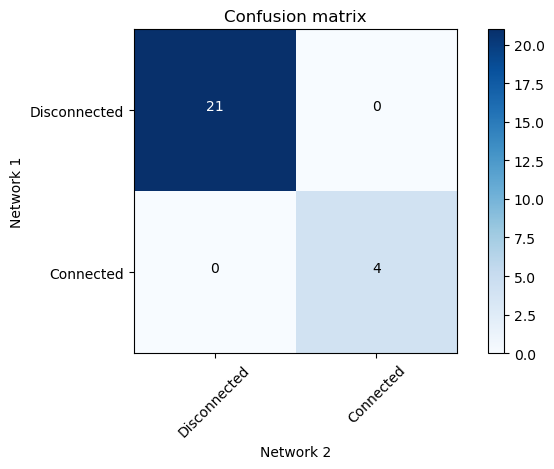

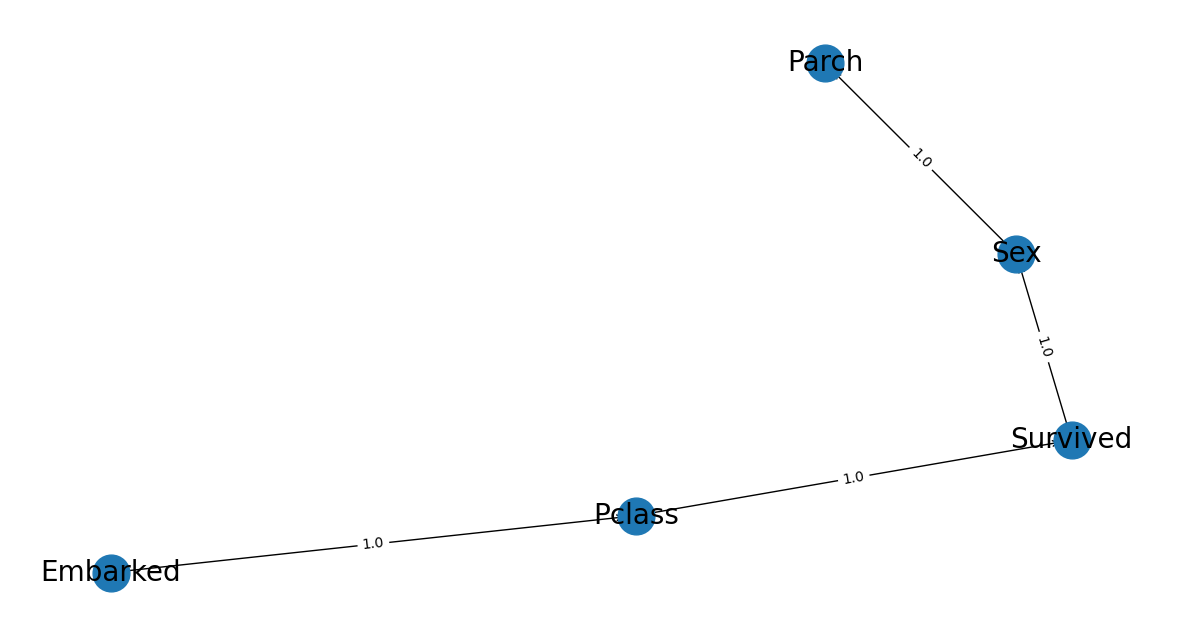

Coincidence - 1.0


In [18]:
# Models comparing
res = bn.bnlearn.compare_networks(model, model2, figsize=(15, 8), verbose=3)
print('Coincidence -', (res[0][0, 0] + res[0][1, 1])/res[0].sum())

In [19]:
%%time
# Make inference
query = bn.inference.fit(model, variables=['Survived'], evidence={'Sex':True, 'Pclass':True})
print(query)
print(query.df)

# Another inference using only sex for evidence
q1 = bn.inference.fit(model, variables=['Survived'], evidence={'Sex':0})
print(query)
print(query.df)

# Print model
bn.print_CPD(model)

[bnlearn] >Variable Elimination.
+----+------------+----------+
|    |   Survived |        p |
+====+============+==========+
|  0 |          0 | 0.566487 |
+----+------------+----------+
|  1 |          1 | 0.433513 |
+----+------------+----------+

Summary for variables: ['Survived']
Given evidence: Sex=True, Pclass=True

Survived outcomes:
- Survived: 0 (56.6%)
- Survived: 1 (43.4%)
+-------------+-----------------+
| Survived    |   phi(Survived) |
+=============+=================+
| Survived(0) |          0.5665 |
+-------------+-----------------+
| Survived(1) |          0.4335 |
+-------------+-----------------+
   Survived         p
0         0  0.566487
1         1  0.433513
[bnlearn] >Variable Elimination.
+----+------------+----------+
|    |   Survived |        p |
+====+============+==========+
|  0 |          0 | 0.419009 |
+----+------------+----------+
|  1 |          1 | 0.580991 |
+----+------------+----------+

Summary for variables: ['Survived']
Given evidence: Sex=

{'Pclass':     Pclass  Embarked         p
 0        1         0  0.338624
 1        1         1  0.383465
 2        1         2  0.268577
 3        1         3  0.245545
 4        2         0  0.330688
 5        2         1  0.259455
 6        2         2  0.274947
 7        2         3  0.275532
 8        3         0  0.330688
 9        3         1  0.357080
 10       3         2  0.456476
 11       3         3  0.478922,
 'Survived':    Survived  Pclass         p
 0         0       1  0.462252
 1         0       2  0.508345
 2         0       3  0.634369
 3         1       1  0.537748
 4         1       2  0.491655
 5         1       3  0.365631,
 'Sex':    Sex  Survived         p
 0    0         0  0.333333
 1    0         1  0.561449
 2    1         0  0.666667
 3    1         1  0.438551,
 'Parch':    Parch  Sex         p
 0      0    0  0.179384
 1      0    1  0.133679
 2      1    0  0.369478
 3      1    1  0.532642
 4      2    0  0.230254
 5      2    1  0.176166
 6      3  

In [20]:
# Prediction using the Bayesian network
Pout = bn.predict(model, df=dfnum_test, variables=['Survived'])
Pout

[bnlearn]> Remaining columns for inference: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 524.32it/s]


,Survived,p
0,0,0.725084
1,0,0.507407
2,0,0.611161
3,0,0.725084
4,0,0.507407
...,...,...
413,0,0.725084
414,1,0.662098
415,0,0.725084
416,0,0.725084


* https://medium.com/data-science/create-a-quantum-bayesian-network-d26d7c5c4217
* https://medium.com/@segunemmanuel46/introduction-to-bayesian-networks-2b62b4d35a52
* https://www.kaggle.com/code/vbmokin/titanic-predict-using-a-simple-bayesian-network
* https://www.kaggle.com/code/dhruvdeshmukh/constructing-the-bayesian-networks-in-python